Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
Epoch 1: F1-score = 0.6000
163/163 ━━━━━━━━━━━━━━━━━━━━ 204s 896ms/step - accuracy: 0.8056 - loss: 0.0592 - val_accuracy: 0.6250 - val_loss: 0.0553 - learning_rate: 1.0000e-04
Epoch 2/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
Epoch 2: F1-score = 0.6250
163/163 ━━━━━━━━━━━━━━━━━━━━ 99s 609ms/step - accuracy: 0.9096 - loss: 0.0302 - val_accuracy: 0.7500 - val_loss: 0.0454 - learning_rate: 1.0000e-04
Epoch 3/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
Epoch 3: F1-score = 0.4444
163/163 ━━━━━━━━━━━━━━━━━━━━ 98s 599ms/step - accuracy: 0.9152 - loss: 0.0236 - val_accuracy: 0.7500 - val_loss: 0.0517 - learning_rate: 1.0000e-04
Epoch 4/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
Epoch 4: F1-score = 0.5556
163/163 ━━━━━━━━━━━━━━━━━━━━ 100s 615ms/step - accuracy: 0.9306 - loss: 0.0205 - val_accuracy: 0.8750 - val_loss: 0.0307 - learning_rate: 1.0000e-04
Epoch 5/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
Epoch 5: F1-score = 0.3750
163/163 ━━━━━━━━━━━━━━

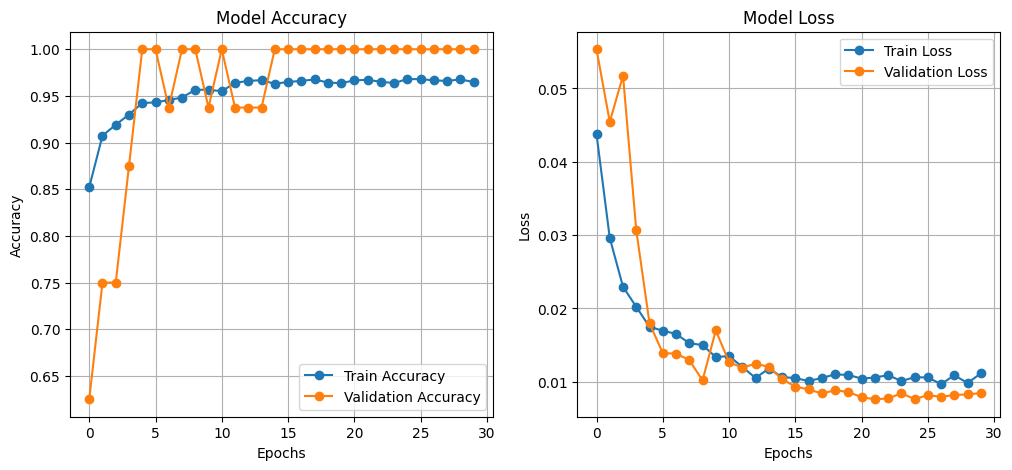

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 215ms/step - accuracy: 0.9045 - loss: 0.0338
✅ Test Accuracy: 0.9279
20/20 ━━━━━━━━━━━━━━━━━━━━ 15s 198ms/step


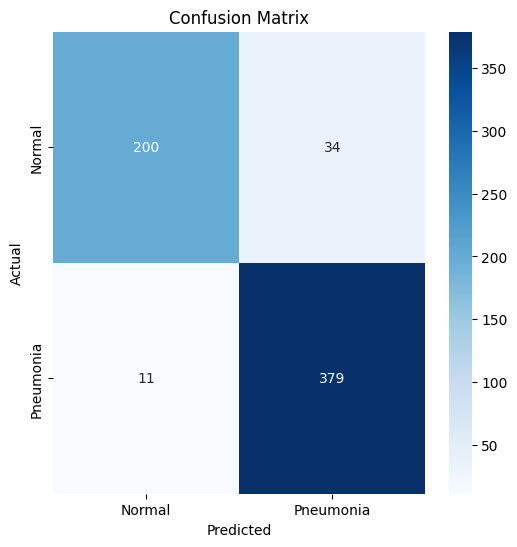


Classification Report:
              precision    recall  f1-score   support

      Normal       0.95      0.85      0.90       234
   Pneumonia       0.92      0.97      0.94       390

    accuracy                           0.93       624
   macro avg       0.93      0.91      0.92       624
weighted avg       0.93      0.93      0.93       624



In [ ]:
import os
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
import matplotlib.pyplot as plt
import seaborn as sns
import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.metrics import confusion_matrix, classification_report, f1_score
from sklearn.utils.class_weight import compute_class_weight
from google.colab import files
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Enable mixed precision training
tf.keras.mixed_precision.set_global_policy("mixed_float16")

# Upload Kaggle API key
files.upload()
!mkdir -p ~/.kaggle && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia --unzip -p /content/dataset

# Dataset Paths
base_dir = "/content/dataset/chest_xray/chest_xray"
train_dir, val_dir, test_dir = [os.path.join(base_dir, x) for x in ["train", "val", "test"]]

# Augmentations using Albumentations
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True,
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir, target_size=(224, 224), batch_size=32, class_mode='binary')
val_generator = test_datagen.flow_from_directory(val_dir, target_size=(224, 224), batch_size=32, class_mode='binary')
test_generator = test_datagen.flow_from_directory(test_dir, target_size=(224, 224), batch_size=32, class_mode='binary', shuffle=False)

# Compute class weights
labels = train_generator.classes
class_weights = compute_class_weight("balanced", classes=np.unique(labels), y=labels)
class_weights = {i: class_weights[i] for i in range(len(class_weights))}

# Define DenseNet-121 Model
base_model = keras.applications.DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze base layers

# Unfreeze last 60 layers
for layer in base_model.layers[-60:]:
    layer.trainable = True

# Model Architecture
inputs = keras.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(1, activation='sigmoid')(x)
model = keras.Model(inputs, x)

# Focal Loss Function
def focal_loss(alpha=0.25, gamma=2.0):
    def loss(y_true, y_pred):
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1 - 1e-7)
        loss = -y_true * alpha * tf.pow(1 - y_pred, gamma) * tf.math.log(y_pred)
        loss -= (1 - y_true) * (1 - alpha) * tf.pow(y_pred, gamma) * tf.math.log(1 - y_pred)
        return tf.reduce_mean(loss)
    return loss

# Compile Model
model.compile(optimizer=keras.optimizers.AdamW(learning_rate=0.0001, weight_decay=1e-4),
              loss=focal_loss(alpha=class_weights[1], gamma=2.0),
              metrics=['accuracy'])

# F1-score callback
class F1ScoreCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        y_pred = (self.model.predict(val_generator) > 0.5).astype(int)
        y_true = val_generator.classes
        f1 = f1_score(y_true, y_pred)
        print(f"Epoch {epoch+1}: F1-score = {f1:.4f}")

f1_callback = F1ScoreCallback()

# Callbacks
checkpoint = keras.callbacks.ModelCheckpoint("pneumonia_densenet.keras", save_best_only=True)
lr_scheduler = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# Train Model
history = model.fit(train_generator, epochs=30, validation_data=val_generator, callbacks=[checkpoint, lr_scheduler, f1_callback])

# Plot Accuracy & Loss Graphs
plt.figure(figsize=(12, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()

plt.show()

# Evaluate Model
test_loss, test_acc = model.evaluate(test_generator)
print(f"✅ Test Accuracy: {test_acc:.4f}")

# Predictions
y_true = test_generator.labels
y_pred = (model.predict(test_generator) > 0.5).astype(int)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Pneumonia'], yticklabels=['Normal', 'Pneumonia'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=['Normal', 'Pneumonia']))

# Upload Image for Prediction with Test-Time Augmentation (TTA)
def predict_image():
    uploaded = files.upload()
    for file_name in uploaded.keys():
        img = keras.preprocessing.image.load_img(file_name, target_size=(224, 224))
        img_array = keras.preprocessing.image.img_to_array(img) / 255.0
        img_array = np.expand_dims(img_array, axis=0)

        # Test-Time Augmentation (TTA)
        predictions = [model.predict(img_array)[0][0] for _ in range(10)]
        prediction = np.mean(predictions)
        result = "Pneumonia" if prediction > 0.5 else "Normal"

        print(f"Prediction: {result} (Confidence: {prediction:.4f})")
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Prediction: {result}")
        plt.show()

predict_image()

